In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
sys.path.append("../")

In [13]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
numpyro.set_host_device_count(8)

import jax
import jax.numpy as jnp
import jax.nn
from jax import random

from src.datamodules.toy_regression_datamodules import ToyRegressionDDataModule
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [14]:
dm = ToyRegressionDDataModule()

In [15]:
X = dm.train_dataloader().dataset.X
y = dm.train_dataloader().dataset.Y

# Load MAP

In [19]:
import pickle

In [20]:
MAP_params = pickle.load(open("map_silu50.pkl", "rb"))

In [21]:
def det_bnn(X, MAP_params, width=50):
    nB, _ = X.shape
    
    W_1 = MAP_params["W1"].T
    b_1 = MAP_params["b1"]
    W_2 = MAP_params["W2"].T
    b_2 = MAP_params["b2"]
    W_3 = MAP_params["W3"].T
    b_3 = MAP_params["b3"]
    W_output = MAP_params["W_output"].T
    b_output = MAP_params["b_output"]
    
    z1 = X @ W_1 + b_1.reshape((1, width)).repeat(nB, axis=0)
    h1 = jax.nn.silu(z1)

    z2 = h1 @ W_2 + b_2.reshape((1, width)).repeat(nB, axis=0)
    h2 = jax.nn.silu(z2)

    z3 = h2 @ W_3 + b_3.reshape((1, width)).repeat(nB, axis=0)
    h3 = jax.nn.silu(z3)
    
    output = h3 @ W_output + b_output
    return output

# subset HMC

In [22]:
def generate_mixed_bnn(MAP_params, sample_mask, rescale_prior = False):
    if not sample_mask:
        sample_mask = [True, True, True, True]
    
    num_params = [100, 2550, 2550, 51]
    
    sampled_params = 0
    for s, n in zip(sample_mask, num_params):
        if s:
            sampled_params += n 
    
    if not rescale_prior:
        prior_scale = 1.0
    else:
        prior_scale = jnp.sqrt((5251/sampled_params))
    
    print(f"Using prior scale {prior_scale}")

    def mixed_bnn(X, y=None, width=50, output_noise_scale=0.05):
        nB, _ = X.shape

        if sample_mask[0]:
            W_1 = numpyro.sample("W1", dist.Normal(0, prior_scale * jnp.ones((1, width))))
            b_1 = numpyro.sample("b1", dist.Normal(0, prior_scale * jnp.ones((width))))
        else:
            W_1 = MAP_params["W1"].T
            b_1 = MAP_params["b1"]

        if sample_mask[1]:
            W_2 = numpyro.sample("W2", dist.Normal(0, prior_scale * jnp.ones((width, width))))
            b_2 = numpyro.sample("b2", dist.Normal(0, prior_scale * jnp.ones((width))))
        else:
            W_2 = MAP_params["W2"].T * (width ** 0.5)
            b_2 = MAP_params["b2"]

        if sample_mask[2]:
            W_3 = numpyro.sample("W3", dist.Normal(0, prior_scale * jnp.ones((width, width))))
            b_3 = numpyro.sample("b3", dist.Normal(0, prior_scale * jnp.ones((width))))
        else:
            W_3 = MAP_params["W3"].T * (width ** 0.5)
            b_3 = MAP_params["b3"]

        if sample_mask[3]:
            W_output = numpyro.sample("W_output", dist.Normal(0, prior_scale * jnp.ones((width, 1))))
            b_output = numpyro.sample("b_output", dist.Normal(0, prior_scale * 1))
        else:
            W_output = MAP_params["W_output"].T * (width ** 0.5)
            b_output = MAP_params["b_output"]

        z1 = X @ W_1 + b_1.reshape((1, width)).repeat(nB, axis=0)
        h1 = jax.nn.silu(z1)

        z2 = (h1 @ W_2)/(width**0.5) + b_2.reshape((1, width)).repeat(nB, axis=0)
        h2 = jax.nn.silu(z2)

        z3 = (h2 @ W_3)/(width**0.5) + b_3.reshape((1, width)).repeat(nB, axis=0)
        h3 = jax.nn.silu(z3)

        output = numpyro.deterministic("output", (h3 @ W_output)/(width**0.5) + b_output)
        y_obs = numpyro.sample("y_obs", dist.Normal(output, output_noise_scale), obs=y)
    
    return mixed_bnn

In [ ]:
for flags in list(itertools.product(*[[False, True] for i in range(4)])):
    if all([f == False for f in flags]):
        continue
    
    print(f"Generating mixed bnn with flags {flags}")
    mixed_bnn = generate_mixed_bnn(MAP_params, flags, rescale_prior=True)

    nuts_kernel = NUTS(mixed_bnn, max_tree_depth=15)
    mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=500, num_chains=8)
    rng_key = random.PRNGKey(0)

    mcmc.run(rng_key, X, y)
    
    name_str = ",".join(
    ["Stoc" if f else "Det" for f in flags]
    )
    fname = f"{name_str}.pkl"
    
    pickle.dump(mcmc.get_samples(), open(fname, "wb"))

# analyse rescale prior results

In [23]:
rng_key = random.PRNGKey(0)

# Intro plot

Using prior scale 1.4349968433380127


FileNotFoundError: [Errno 2] No such file or directory: 'Det,Stoc,Det,Det.pkl'

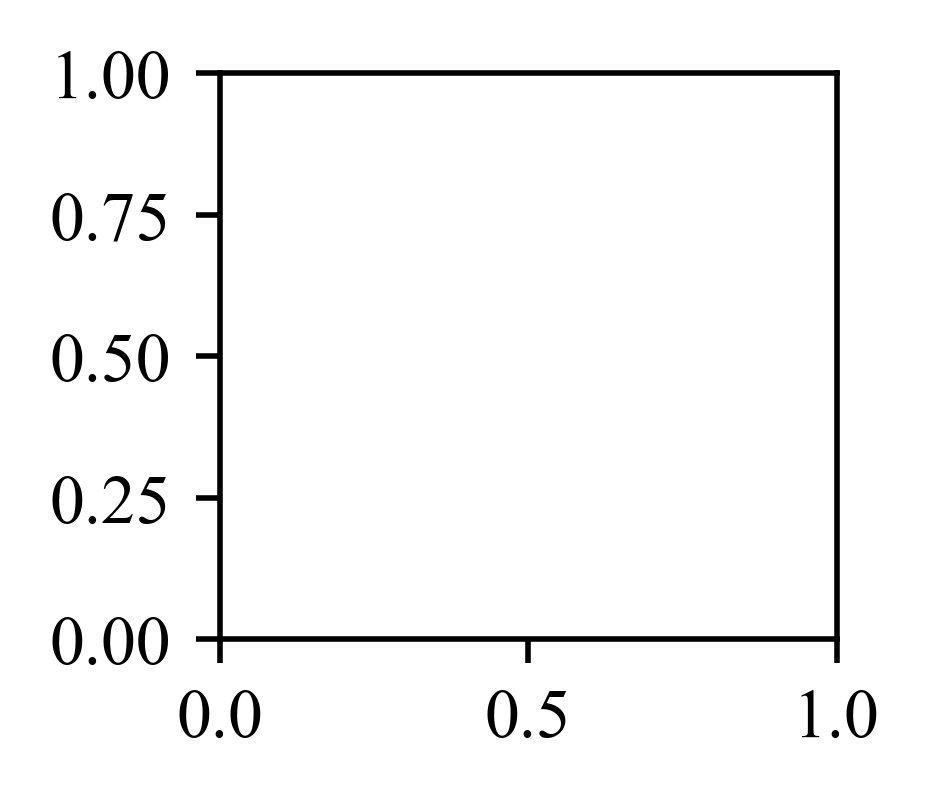

In [24]:
plt.figure(figsize=(3.5, 1.5), dpi=500)
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
colors = sns.color_palette("colorblind")

configs = [
    # ([False, False, False, False], "Deterministic Network", "<10s"),
    # ([False, False, False, True], "Output layer (51)", "7s"),
    # ([True, False, False, False], "Input layer (100)", "837s"),
    # ([False, False, True, False], "Second hidden layer (2550)", "89s"),
    ([False, True, False, False], "(a) HMC on First Hidden Layer", "122s"),
    # ([False, False, True, True], "Last two layers (2601)", "151s"),
    ([True, True, True, True], "(b) HMC on All Layers", "897s")
]

n_grid = 50

for f_i, config in enumerate(configs):
    flags, title, runtime_str = config
    plt.subplot(1, len(configs), f_i+1)
    label_str = f"Runtime: {runtime_str}"
    if all([f == False for f in flags]):
        X_pred = jnp.linspace(-6, 6, 300)
        X_pred = X_pred.reshape((300, 1))

        y_pred = det_bnn(X_pred, MAP_params)
        plt.plot(X_pred, y_pred, color="dimgray", zorder=1, label=label_str, linewidth=1)
        plt.scatter(X, y, color=colors[-3], s=5, marker='.', zorder=2)
        plt.title("MAP", fontsize=6)
        
    else:
        mixed_bnn = generate_mixed_bnn(MAP_params, flags, rescale_prior=True)

        name_str = ",".join(
        ["Stoc" if f else "Det" for f in flags]
        )
        fname = f"{name_str}.pkl"

        mcmc_samples = pickle.load(open(fname, "rb"))
        

        X_pred = jnp.linspace(-6, 6, n_grid)
        predictive = Predictive(mixed_bnn, mcmc_samples)
        y_pred = predictive(rng_key, X=X_pred.reshape((n_grid, 1)))["output"]
        
        color = colors[1] if f_i < 1 else colors[0]
        plt.plot(X_pred, y_pred.mean(axis=0), zorder=1, label=label_str, color=color, linewidth=1)
        plt.fill_between(X_pred, y_pred.mean(axis=0).flatten() - y_pred.std(axis=0).flatten(), y_pred.mean(axis=0).flatten() + y_pred.std(axis=0).flatten(), alpha=0.5, zorder=1, color=color, linewidth=0)
        plt.fill_between(X_pred, y_pred.mean(axis=0).flatten() - 2 * y_pred.std(axis=0).flatten(), y_pred.mean(axis=0).flatten() + 2 * y_pred.std(axis=0).flatten(), alpha=0.25, zorder=1, color=color, linewidth=0)
        plt.fill_between(X_pred, y_pred.mean(axis=0).flatten() - 3 * y_pred.std(axis=0).flatten(), y_pred.mean(axis=0).flatten() + 3 * y_pred.std(axis=0).flatten(), alpha=0.125, zorder=1, color=color, linewidth=0)
        plt.scatter(X, y, color=colors[-3], s=5, marker='.', zorder=2)
        
        plt.title(name_str, fontsize=6)
    
    # plt.legend(fontsize=5)
    plt.xticks([])
    plt.yticks([])
    plt.ylim((-5, 10))
    plt.xlim((-6, 6))
    plt.title(title, fontsize=8)
            
plt.tight_layout(w_pad=0.0)
plt.savefig("toy_hmc_intro.pdf", bbox_inches="tight")

# more configs plot

In [ ]:
plt.figure(figsize=(6.75, 1.5), dpi=300)
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
colors = sns.color_palette("colorblind")

configs = [
    ([False, False, False, False], "MAP (0)", "<10s"),
    ([False, False, False, True], "Output layer (51)", "7s"),
    ([True, False, False, False], "Input layer (100)", "837s"),
    ([False, False, True, False], "Second hidden layer (2550)", "89s"),
    ([False, True, False, False], "First hidden layer (2550)", "122s"),
    ([False, False, True, True], "Last two layers (2601)", "151s"),
    ([True, True, True, True], "All layers (5251)", "897s")
]

n_grid = 50

for f_i, config in enumerate(configs):
    flags, title, runtime_str = config
    plt.subplot(1, 7, f_i+1)
    label_str = f"Runtime: {runtime_str}"
    if all([f == False for f in flags]):
        X_pred = jnp.linspace(-6, 6, 300)
        X_pred = X_pred.reshape((300, 1))

        y_pred = det_bnn(X_pred, MAP_params)
        plt.plot(X_pred, y_pred, color=colors[-3], zorder=1, label=label_str, linewidth=1)
        plt.scatter(X, y, color=colors[-3], s=5, marker='.', zorder=2)
        plt.title("MAP", fontsize=6)
        
    else:
        mixed_bnn = generate_mixed_bnn(MAP_params, flags, rescale_prior=True)

        name_str = ",".join(
        ["Stoc" if f else "Det" for f in flags]
        )
        fname = f"{name_str}_longer_samples_ntk_param_rescale_prior.pkl"

        mcmc_samples = pickle.load(open(fname, "rb"))
        

        X_pred = jnp.linspace(-6, 6, n_grid)
        predictive = Predictive(mixed_bnn, mcmc_samples)
        y_pred = predictive(rng_key, X=X_pred.reshape((n_grid, 1)))["output"]
        
        
        color = colors[1] if f_i < 6 else colors[0]
        plt.plot(X_pred, y_pred.mean(axis=0), zorder=1, label=label_str, color=color, linewidth=1)
        plt.fill_between(X_pred, y_pred.mean(axis=0).flatten() - y_pred.std(axis=0).flatten(), y_pred.mean(axis=0).flatten() + y_pred.std(axis=0).flatten(), alpha=0.5, zorder=1, color=color, linewidth=0)
        plt.fill_between(X_pred, y_pred.mean(axis=0).flatten() - 2 * y_pred.std(axis=0).flatten(), y_pred.mean(axis=0).flatten() + 2 * y_pred.std(axis=0).flatten(), alpha=0.25, zorder=1, color=color, linewidth=0)
        plt.fill_between(X_pred, y_pred.mean(axis=0).flatten() - 3 * y_pred.std(axis=0).flatten(), y_pred.mean(axis=0).flatten() + 3 * y_pred.std(axis=0).flatten(), alpha=0.125, zorder=1, color=color, linewidth=0)
        plt.scatter(X, y, color=colors[-3], s=5, marker='.', zorder=2)
        
        plt.title(name_str, fontsize=6, color=color)
    
    plt.legend(fontsize=5)
    plt.xticks([])
    plt.yticks([])
    plt.ylim((-5, 10))
    plt.xlim((-6, 6))
    plt.title(title, fontsize=6)
            
plt.tight_layout(w_pad=-0.25, h_pad=0)
plt.savefig("toy_hmc.pdf", bbox_inches="tight")